# 数据加载、时间序列转换与可视化

本 notebook 从已保存的 CSV 文件加载数据，转换为时间序列格式（适配 pysindy），并进行可视化

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

import matplotlib.pyplot as plt
import pickle   
import numpy as np  
from datetime import datetime  
import pandas as pd
import scipy
import seaborn as sns
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools.tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from tools.tools import split_and_group_matrices, plot_macro_serie
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from read_data_improved import main, format_timeseries_data

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 步骤 1: 生成并保存数据

In [2]:
# print("="*60)
# print("生成训练和测试数据...")
# print("="*60)
# main(atten_type = 1, trial_type = 1)

## 步骤 2: 从 CSV 文件加载数据

In [2]:
print("\n" + "="*60)
print("加载保存的数据...")
print("="*60)

train_data = {}
test_data = {}

for stage in [1, 2, 3]:
    base_path = f'./visual_inducted_conscious/1/stage{stage}'
    train_data[stage] = np.load(f'{base_path}/train_seqs.npy')  
    test_data[stage] = np.load(f'{base_path}/test_seqs.npy')  
    



加载保存的数据...


## 步骤 5: 绘制时间序列图

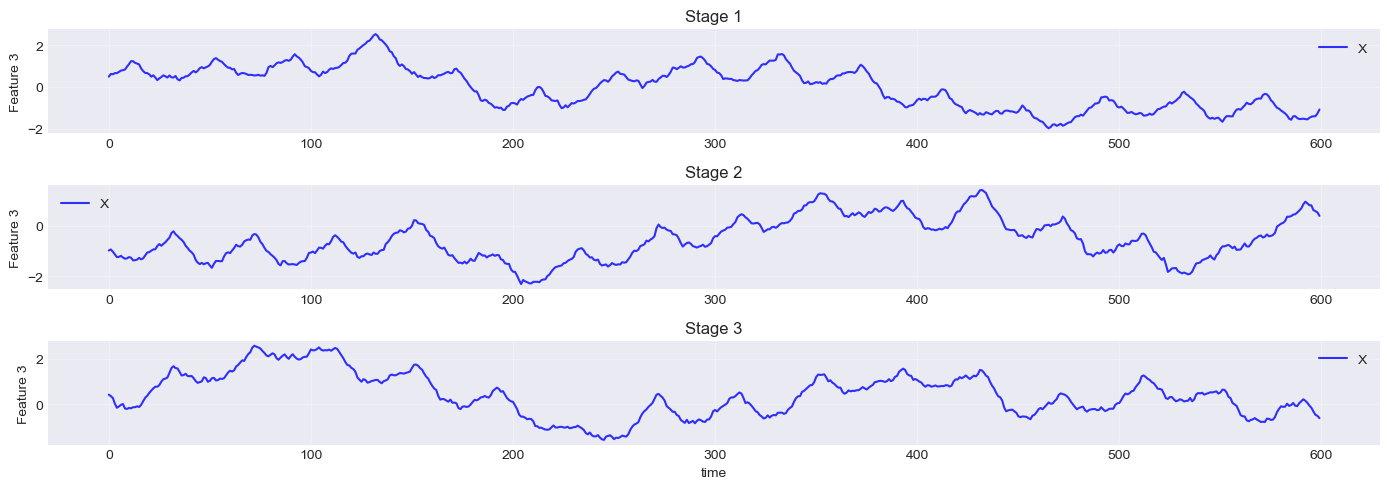

✓ 时间序列图绘制完成


In [128]:
# 绘制 3 个阶段的时间序列
fig, axes = plt.subplots(3, 1, figsize=(14, 5))
feature = 3  # 只绘制第一个特征

for idx, stage in enumerate([1, 2, 3]):
    # 获取数据
    X_train = train_data[stage][0]
    
    # 绘制特征值
    axes[idx].plot(X_train[:, feature], 'b-', linewidth=1.5, alpha=0.8, label='X')
    axes[idx].set_ylabel(f'Feature {feature}')
    axes[idx].set_title(f'Stage {stage}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    

axes[2].set_xlabel('time')
plt.tight_layout()
plt.show()

print("✓ 时间序列图绘制完成")

## 数据准备, 选择stage

In [109]:
stage = 2
x_data = []
for i in range(len(train_data[stage])):
    x_data.append(train_data[stage][i])
micro_name = []
for i in range(x_data[0].shape[1]):
    micro_name.append('x'+str(i))
micro_name, x_data[0].shape, len(x_data)

(['x0',
  'x1',
  'x2',
  'x3',
  'x4',
  'x5',
  'x6',
  'x7',
  'x8',
  'x9',
  'x10',
  'x11',
  'x12',
  'x13',
  'x14',
  'x15',
  'x16',
  'x17',
  'x18',
  'x19',
  'x20',
  'x21',
  'x22',
  'x23',
  'x24',
  'x25',
  'x26',
  'x27',
  'x28',
  'x29',
  'x30',
  'x31',
  'x32',
  'x33',
  'x34',
  'x35',
  'x36',
  'x37',
  'x38',
  'x39',
  'x40',
  'x41',
  'x42',
  'x43',
  'x44',
  'x45',
  'x46',
  'x47',
  'x48',
  'x49',
  'x50',
  'x51',
  'x52',
  'x53',
  'x54',
  'x55',
  'x56',
  'x57',
  'x58',
  'x59',
  'x60',
  'x61',
  'x62',
  'x63',
  'x64',
  'x65',
  'x66',
  'x67',
  'x68',
  'x69',
  'x70',
  'x71',
  'x72',
  'x73',
  'x74',
  'x75',
  'x76',
  'x77',
  'x78',
  'x79',
  'x80',
  'x81',
  'x82',
  'x83',
  'x84',
  'x85',
  'x86',
  'x87',
  'x88',
  'x89',
  'x90',
  'x91',
  'x92',
  'x93',
  'x94',
  'x95',
  'x96',
  'x97',
  'x98',
  'x99',
  'x100',
  'x101',
  'x102',
  'x103',
  'x104',
  'x105',
  'x106',
  'x107',
  'x108',
  'x109',
  'x110',


# 选择观测函数

In [152]:
# n_delays = 3
# delay_interval = 5
# H, names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
# x_data_lift = H


# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False,interaction_only=True)
library_functions = [
    lambda x: x,
    lambda x: x**2
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide #+ fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

print(x_data_lift[0].shape)
print(names)

(600, 141)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x136', 'x

检测到 139 条轨迹
各轨迹时间步数: [600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
总样本数 M = 83400
观测函数个数 N = 141
使用均匀权重（所有样本等权重）
Gram 矩阵形状: (141, 141)
Gram矩阵形状: (141, 141)
Gram矩阵:
[[ 1.03500458  0.91676028  0.80864595 ...  0.3607339   0.41428861
   0.01395283]
 [ 0.91676028  1.1200597   0.98737113 ...  0.44449755  0.50184417
   0.01392176]
 [ 0.80864595  0.9873711

<Axes: >

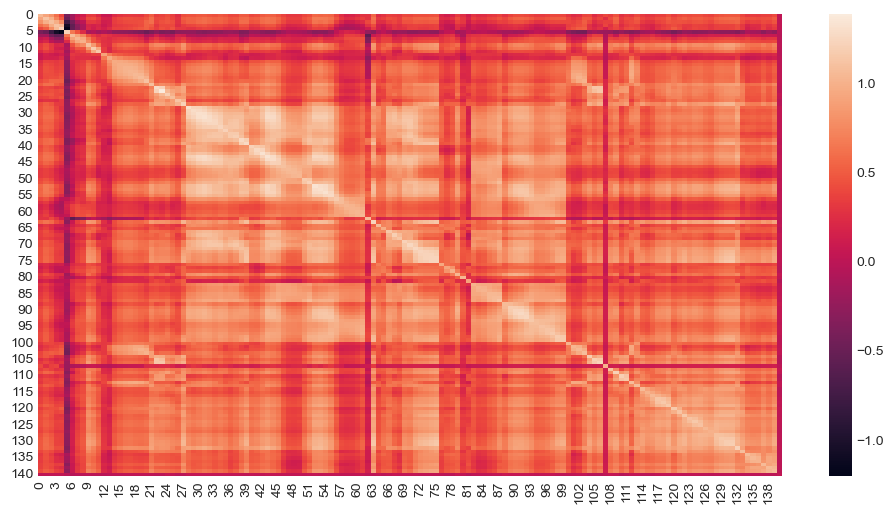

In [153]:
from typing import Callable, List, Tuple

def compute_gram_matrix_for_sindy(library, sample_points_list, weights=None):
    """
    专门为 PySINDy Library 对象优化的 Gram 矩阵计算函数
    
    参数：
    -----------
    library : ConcatLibrary 或其他 SINDy Library 对象
        观测函数库
    sample_points : np.ndarray
        采样点数据，形状为 (M, state_dim)
    weights : np.ndarray, optional
        权重，形状为 (M,)
    """
    
    all_samples = []
    trajectory_lengths = []
    
    for traj in sample_points_list:
        if isinstance(traj, np.ndarray):
            all_samples.append(traj)
            trajectory_lengths.append(traj.shape[0])
        else:
            raise TypeError(f"每个时间序列应该是 np.ndarray，得到 {type(traj)}")
    
    # 合并所有样本点
    X_all = np.vstack(all_samples)  # 形状 (总样本数 M, 状态维数 state_dim)
    M = X_all.shape[0]  # 总样本数
    num_trajectories = len(sample_points_list)
    
    print(f"检测到 {num_trajectories} 条轨迹")
    print(f"各轨迹时间步数: {trajectory_lengths}")
    print(f"总样本数 M = {M}")
    
    # ========== 步骤2：使用 library 计算观测函数值 ==========
    Phi = library.transform(X_all)  # 形状 (M, N)
    M_check, N = Phi.shape
    
    print(f"观测函数个数 N = {N}")
    assert M_check == M, f"样本数不匹配: {M_check} != {M}"
    
    # ========== 步骤3：处理权重 ==========
    if weights is None or weights == "uniform":
        # 所有样本点等权重
        w = np.ones(M) / M
        print("使用均匀权重（所有样本等权重）")
        
    elif weights == "traj":
        # 按轨迹等权重：每条轨迹的权重和为 1/num_trajectories
        w = np.zeros(M)
        idx = 0
        for traj_len in trajectory_lengths:
            # 该条轨迹内部的点等权重
            w[idx : idx + traj_len] = 1.0 / (num_trajectories * traj_len)
            idx += traj_len
        print(f"使用轨迹等权重（每条轨迹权重和 = {1/num_trajectories:.4f}）")
        
    elif isinstance(weights, np.ndarray):
        # 自定义权重
        if len(weights) != M:
            raise ValueError(f"权重长度 {len(weights)} 与总样本数 {M} 不匹配")
        w = weights / np.sum(weights)  # 归一化
        print("使用自定义权重")
        
    else:
        raise ValueError(f"不支持的权重类型: {type(weights)}")
    
    # ========== 步骤4：计算 Gram 矩阵 ==========
    # G_ij = (1/M) * Σ Phi[m, i] * conj(Phi[m, j]) 加权版本
    # 矩阵形式：G = Phi.T @ diag(w) @ Phi
    
    # 高效的向量化计算
    Phi_weighted = Phi * w[:, np.newaxis]  # 形状 (M, N)，每行乘以对应的权重
    G = Phi_weighted.T @ Phi  # 形状 (N, N)
    
    # 如果都是实数，返回实矩阵
    if np.allclose(G.imag, 0):
        G = G.real
    
    print(f"Gram 矩阵形状: {G.shape}")
        
    return G


#ob_func = lambda x : library.transform(x)

G = compute_gram_matrix_for_sindy(library, x_data)

print(f"Gram矩阵形状: {G.shape}")
print(f"Gram矩阵:\n{G}")
print(f"\n矩阵是否对称: {np.allclose(G, G.T)}")
print(f"矩阵条件数: {np.linalg.cond(G):.4f}")
print(f"矩阵特征值: {np.linalg.eigvals(G)}")
sns.heatmap(G)


# 进行拟合

In [72]:
discrete_time = True
dt = 1
thresholds = np.logspace(-1, 1, 7)
print(thresholds)
model, results = fit_sindy_sr3_robust(x_data_lift, ide, names, penalty='l1', discrete_time=discrete_time, max_iter=500, thresholds=thresholds, metric='aic', tol=1e-4, nu=1)

[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
✓ 检测到 139 个时间序列（单独拟合，不拼接）
  序列 1: 600 个样本, 423 个维度
  序列 2: 600 个样本, 423 个维度
  序列 3: 600 个样本, 423 个维度
  序列 4: 600 个样本, 423 个维度
  序列 5: 600 个样本, 423 个维度
  序列 6: 600 个样本, 423 个维度
  序列 7: 600 个样本, 423 个维度
  序列 8: 600 个样本, 423 个维度
  序列 9: 600 个样本, 423 个维度
  序列 10: 600 个样本, 423 个维度
  序列 11: 600 个样本, 423 个维度
  序列 12: 600 个样本, 423 个维度
  序列 13: 600 个样本, 423 个维度
  序列 14: 600 个样本, 423 个维度
  序列 15: 600 个样本, 423 个维度
  序列 16: 600 个样本, 423 个维度
  序列 17: 600 个样本, 423 个维度
  序列 18: 600 个样本, 423 个维度
  序列 19: 600 个样本, 423 个维度
  序列 20: 600 个样本, 423 个维度
  序列 21: 600 个样本, 423 个维度
  序列 22: 600 个样本, 423 个维度
  序列 23: 600 个样本, 423 个维度
  序列 24: 600 个样本, 423 个维度
  序列 25: 600 个样本, 423 个维度
  序列 26: 600 个样本, 423 个维度
  序列 27: 600 个样本, 423 个维度
  序列 28: 600 个样本, 423 个维度
  序列 29: 600 个样本, 423 个维度
  序列 30: 600 个样本, 423 个维度
  序列 31: 600 个样本, 423 个维度
  序列 32: 600 个样本, 423 个维度
  序列 33: 600 个样本, 423 个维度
  序列 34: 600 个样本, 423 个维度
  序列 35: 600

参数扫描 (l1): 100%|██████████| 7/7 [11:18<00:00, 96.99s/it] 



最佳模型 (AIC) | Penalty: L1
参数 (Threshold): 4.642e+00
参数 (Lambda):    4.642e+00
MSE:         3.7590e-03
k:   506.0
评分 (aic):  -5688.3225

发现的方程:
(x0)[k+1] = 0.996 x0[k]
(x1)[k+1] = 0.998 x1[k]
(x2)[k+1] = 0.996 x2[k]
(x3)[k+1] = 0.995 x3[k]
(x4)[k+1] = 0.958 x4[k] + -0.038 x5[k]
(x5)[k+1] = -0.120 x4[k] + 0.877 x5[k]
(x6)[k+1] = 0.932 x6[k] + -0.120 x107[k] + 0.071 sin(1 x6)[k]
(x7)[k+1] = 0.986 x7[k] + -0.056 x107[k] + -0.072 sin(1 x107)[k]
(x8)[k+1] = 0.989 x8[k] + -0.046 x107[k] + -0.078 sin(1 x107)[k]
(x9)[k+1] = 0.996 x9[k] + -0.040 x107[k] + -0.061 sin(1 x107)[k]
(x10)[k+1] = 0.998 x10[k] + -0.062 x107[k]
(x11)[k+1] = 0.999 x11[k] + -0.055 x107[k]
(x12)[k+1] = 0.997 x12[k]
(x13)[k+1] = 0.996 x13[k] + -0.064 x107[k]
(x14)[k+1] = 0.997 x14[k] + -0.070 x107[k]
(x15)[k+1] = -0.006 x14[k] + 1.005 x15[k] + -0.071 x107[k]
(x16)[k+1] = -0.010 x15[k] + 1.008 x16[k] + -0.071 x107[k]
(x17)[k+1] = 0.999 x17[k] + -0.067 x107[k]
(x18)[k+1] = 1.000 x18[k] + -0.066 x107[k]
(x19)[k+1] = 1.001 x19[k

In [111]:
# 离散的迭代方程 or 连续的微分方程
discrete_time = True
dt = 1
ide = ps.IdentityLibrary()
# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.001, max_iter=20000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=True)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)[k+1] = 0.994 x0[k] + 0.004 x1[k] + 0.002 x6[k] + 0.002 x7[k] + -0.001 x26[k] + -0.001 x38[k] + 0.014 x61[k] + -0.048 x62[k] + 0.001 x65[k] + 0.002 x94[k] + 0.015 x98[k] + -0.004 x107[k] + 0.001 x109[k] + 0.001 x122[k] + 0.003 x127[k] + 0.002 x132[k] + 0.001 x137[k] + 0.007 cos(1 x6)[k] + 0.003 cos(1 x8)[k] + 0.006 cos(1 x62)[k] + -0.017 cos(1 x107)[k]
(x1)[k+1] = 0.999 x1[k] + 0.003 x7[k] + 0.001 x10[k] + -0.002 x26[k] + 0.004 x60[k] + 0.002 x61[k] + -0.022 x62[k] + 0.001 x65[k] + 0.001 x94[k] + 0.008 x98[k] + -0.014 x107[k] + 0.002 x109[k] + 0.001 x127[k] + 0.002 cos(1 x6)[k] + -0.001 cos(1 x107)[k]
(x2)[k+1] = 0.015 x1[k] + 0.976 x2[k] + 0.008 x3[k] + 0.002 x7[k] + 0.001 x21[k] + -0.002 x26[k] + 0.012 x61[k] + -0.040 x62[k] + 0.003 x94[k] + 0.012 x98[k] + 0.003 x127[k] + 0.001 x137[k] + 0.008 cos(1 x6)[k] + 0.003 cos(1 x8)[k] + 0.001 cos(1 x16)[k] + 0.007 cos(1 x62)[k] + 0.018 sin(1 x107)[k] + -0.018 cos(1 x107)[k]
(x3)[k+1] = 0.014 x2[k] + 0.970 x3[k] + -0.014 x5[k] + 0.002 x7[

In [88]:
model.score(x_data_lift, t=dt)

0.9914209246635437

In [112]:
model.score(x_data_lift, t=dt)

0.9896685481071472

In [61]:
model.score(x_data_lift, t=dt)

0.99663893514344

# 保存模型

In [113]:
def save_model_pickle(model, filepath):  
    """  
    使用 pickle 保存 SINDy 模型  
    """  
    with open(filepath, 'wb') as f:  
        pickle.dump(model, f)  
    print(f"✓ 模型已保存到: {filepath}")  

def load_model_pickle(filepath):  
    """  
    使用 pickle 加载 SINDy 模型  
    """  
    with open(filepath, 'rb') as f:  
        model = pickle.load(f)  
    print(f"✓ 模型已加载: {filepath}")  
    return model  

print("\n=== 方式1：简单保存（pickle）===")  
save_model_pickle(model, f'stage{stage}_dis_{discrete_time}_fourier.pkl')  
model = load_model_pickle(f'stage{stage}_dis_{discrete_time}_fourier.pkl')  
model.print()


=== 方式1：简单保存（pickle）===
✓ 模型已保存到: stage2_dis_True_fourier.pkl
✓ 模型已加载: stage2_dis_True_fourier.pkl
(x0)[k+1] = 0.994 x0[k] + 0.004 x1[k] + 0.002 x6[k] + 0.002 x7[k] + -0.001 x26[k] + -0.001 x38[k] + 0.014 x61[k] + -0.048 x62[k] + 0.001 x65[k] + 0.002 x94[k] + 0.015 x98[k] + -0.004 x107[k] + 0.001 x109[k] + 0.001 x122[k] + 0.003 x127[k] + 0.002 x132[k] + 0.001 x137[k] + 0.007 cos(1 x6)[k] + 0.003 cos(1 x8)[k] + 0.006 cos(1 x62)[k] + -0.017 cos(1 x107)[k]
(x1)[k+1] = 0.999 x1[k] + 0.003 x7[k] + 0.001 x10[k] + -0.002 x26[k] + 0.004 x60[k] + 0.002 x61[k] + -0.022 x62[k] + 0.001 x65[k] + 0.001 x94[k] + 0.008 x98[k] + -0.014 x107[k] + 0.002 x109[k] + 0.001 x127[k] + 0.002 cos(1 x6)[k] + -0.001 cos(1 x107)[k]
(x2)[k+1] = 0.015 x1[k] + 0.976 x2[k] + 0.008 x3[k] + 0.002 x7[k] + 0.001 x21[k] + -0.002 x26[k] + 0.012 x61[k] + -0.040 x62[k] + 0.003 x94[k] + 0.012 x98[k] + 0.003 x127[k] + 0.001 x137[k] + 0.008 cos(1 x6)[k] + 0.003 cos(1 x8)[k] + 0.001 cos(1 x16)[k] + 0.007 cos(1 x62)[k] + 0.018 sin

# 加载模型

In [151]:
stage = 1
discrete_time = True
model = load_model_pickle(f'stage{stage}_dis_{discrete_time}.pkl')  
model.print()

✓ 模型已加载: stage1_dis_True.pkl
(x0)[k+1] = 1.004 x0[k] + -0.043 x62[k]
(x1)[k+1] = 0.998 x1[k]
(x2)[k+1] = 0.036 x1[k] + 0.957 x2[k] + 0.014 x3[k] + -0.033 x62[k] + 0.015 x107[k]
(x3)[k+1] = 0.998 x3[k] + -0.042 x62[k] + 0.017 x107[k]
(x4)[k+1] = 0.902 x4[k] + -0.097 x5[k] + -0.021 x62[k]
(x5)[k+1] = -0.019 x3[k] + -0.165 x4[k] + 0.810 x5[k] + -0.031 x107[k]
(x6)[k+1] = 0.979 x6[k] + -0.119 x107[k]
(x7)[k+1] = 0.985 x7[k] + -0.109 x107[k]
(x8)[k+1] = 0.989 x8[k] + -0.103 x107[k]
(x9)[k+1] = 0.996 x9[k] + -0.085 x107[k]
(x10)[k+1] = 0.998 x10[k] + -0.062 x107[k]
(x11)[k+1] = 0.999 x11[k] + -0.055 x107[k]
(x12)[k+1] = 0.996 x12[k] + -0.053 x107[k]
(x13)[k+1] = 0.996 x13[k] + -0.064 x107[k]
(x14)[k+1] = 0.997 x14[k] + -0.070 x107[k]
(x15)[k+1] = -0.006 x14[k] + 1.005 x15[k] + -0.071 x107[k]
(x16)[k+1] = -0.010 x15[k] + 1.008 x16[k] + -0.071 x107[k]
(x17)[k+1] = 0.999 x17[k] + -0.067 x107[k]
(x18)[k+1] = 0.977 x18[k] + 0.024 x19[k] + -0.066 x107[k]
(x19)[k+1] = 1.001 x19[k] + -0.059 x107[k]


# 多步预测

In [154]:
# # 单时间序列
# init_data = x_data_lift[0,:]
# # 多时间序列
test_idx = 100
init_data = x_data_lift[test_idx][0,:]
step_pred = 10
t = range(step_pred)

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(10, 141)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/2295418408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


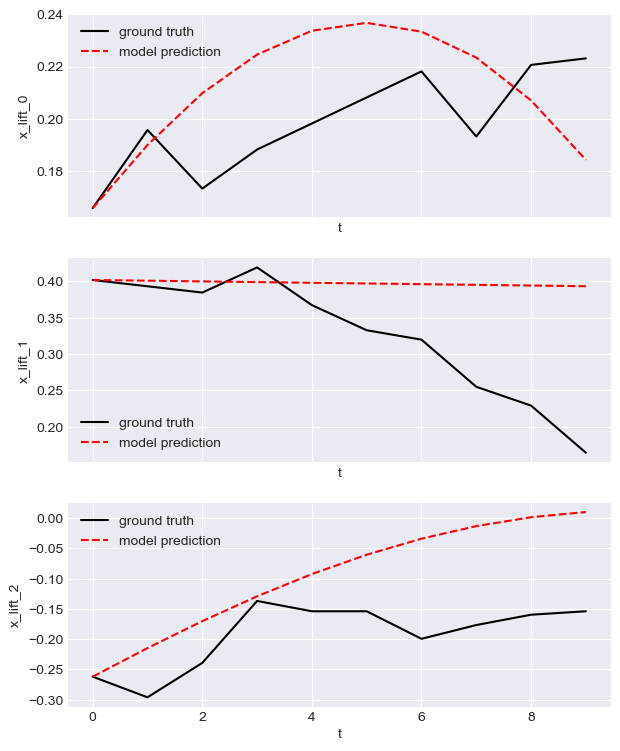

In [155]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[test_idx][:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# 分析K

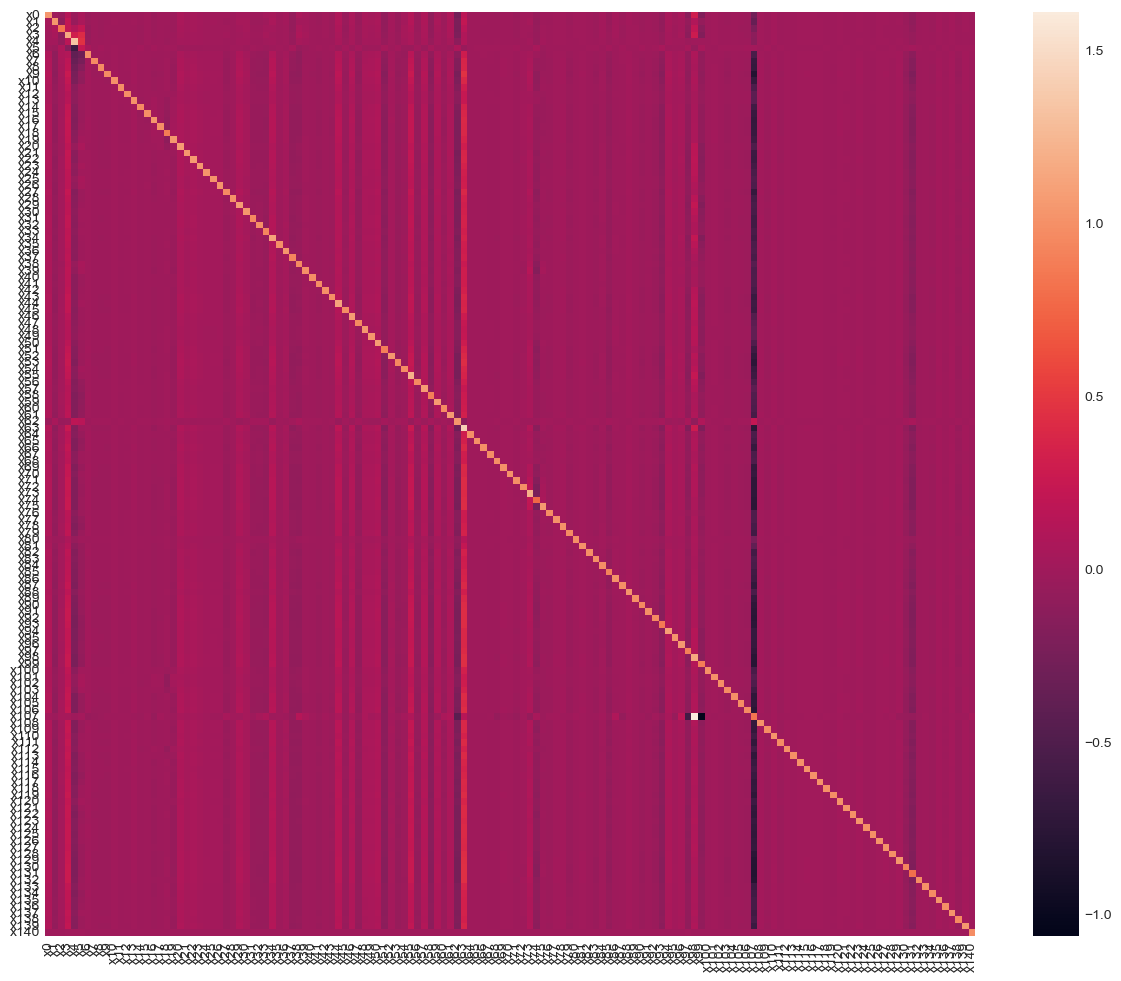

In [156]:
from scipy.linalg import sqrtm, fractional_matrix_power, eigh

A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

G_sqrt = sqrtm(G).real
G_inv_sqrt = sqrtm(np.linalg.inv(G)).real
A = G_sqrt @ A @ G_inv_sqrt

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

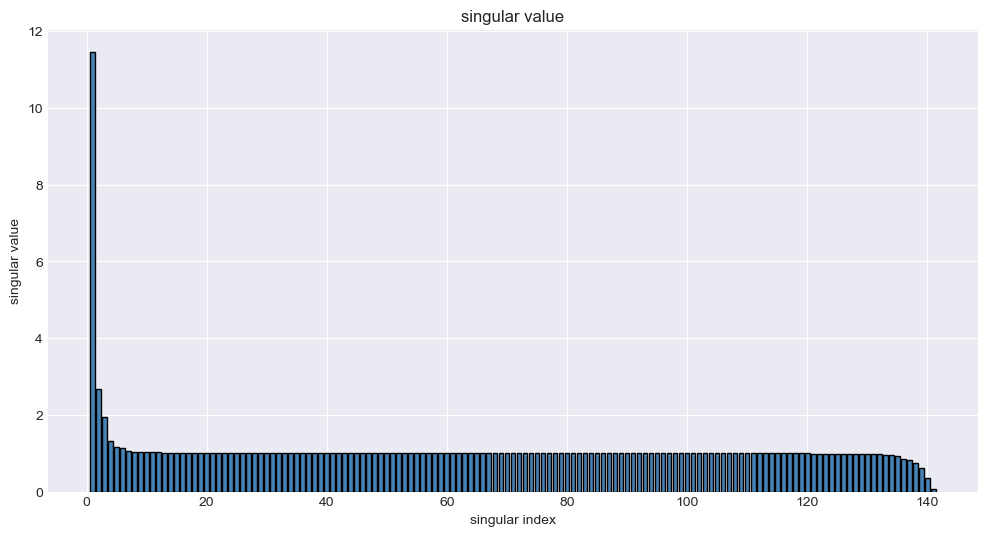

In [157]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

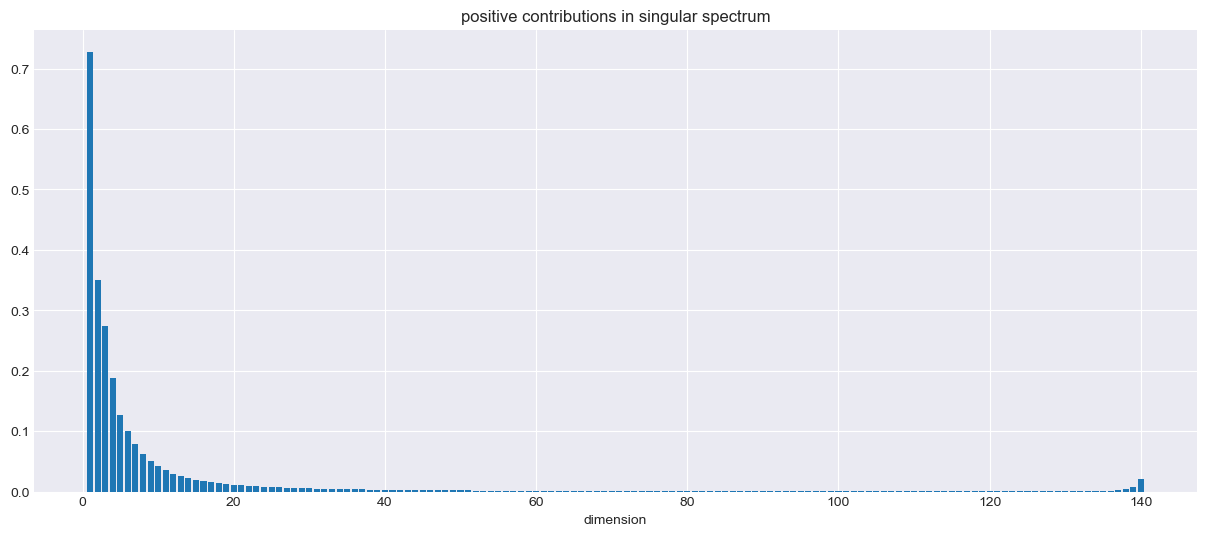

In [158]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [159]:
# stage 1
print(compute_entropy(diff))

3.969708833647912


In [119]:
# stage 2
print(compute_entropy(diff))

4.2661376


In [68]:
# stage 3
print(compute_entropy(diff))

3.1222699072617566


In [160]:
# stage1
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

10.385941780006885


In [122]:
# stage2
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.41229314


In [69]:
# stage3
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.30959874522713104


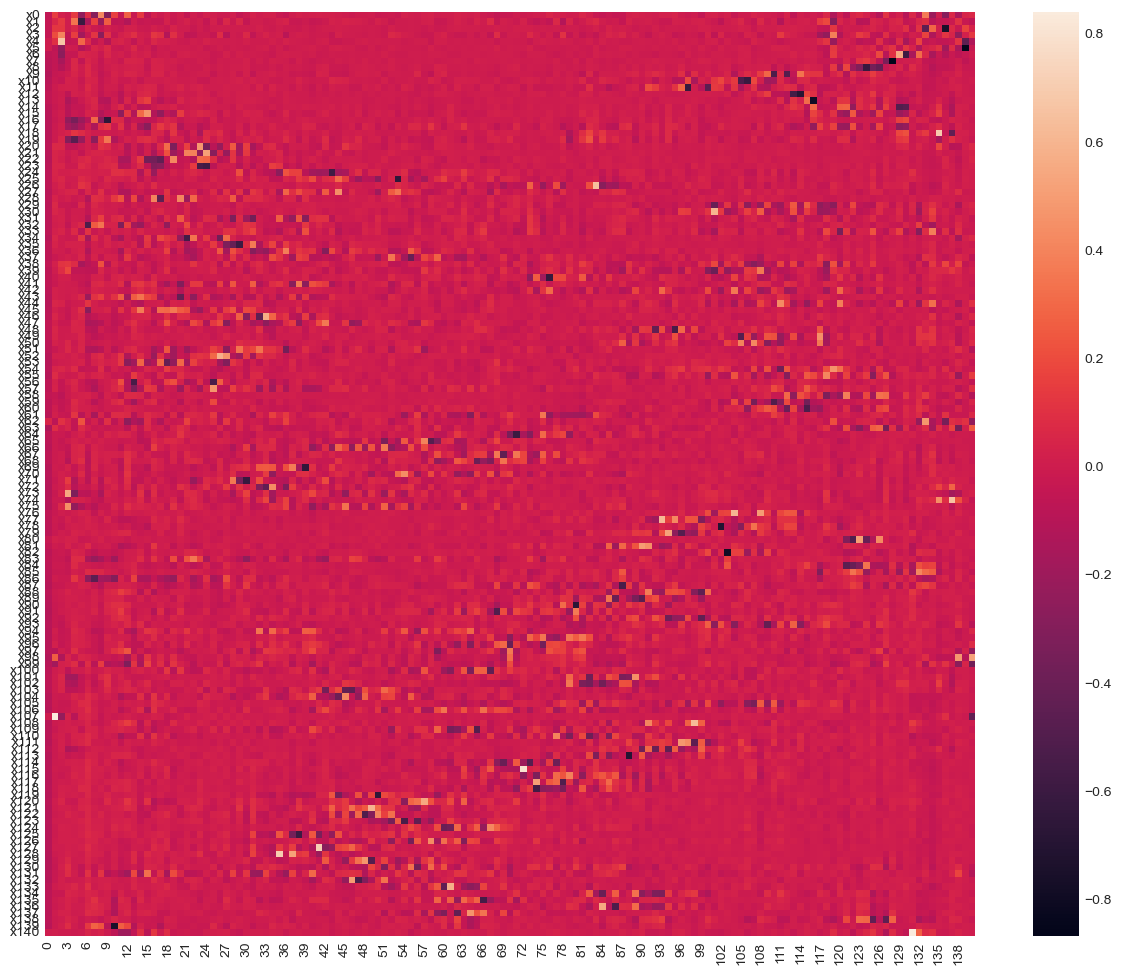

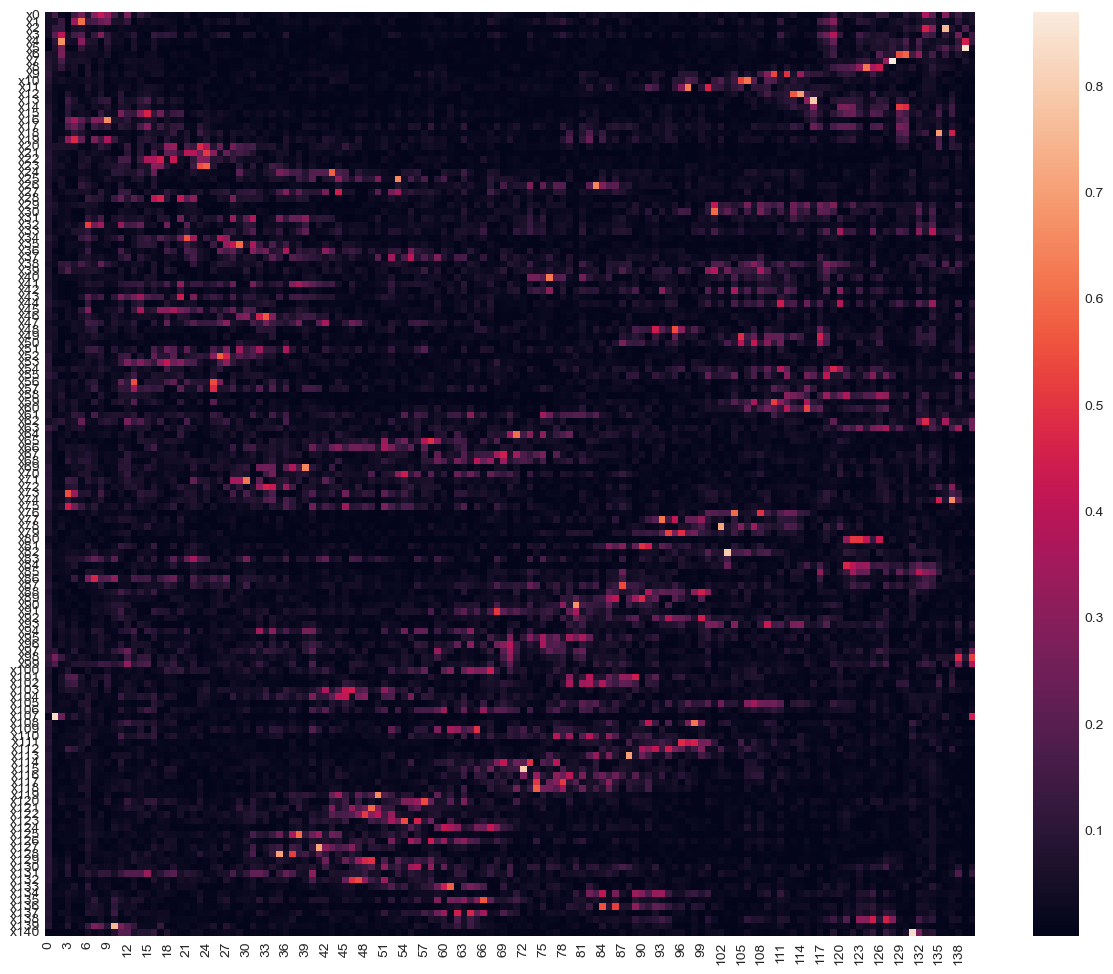

In [161]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

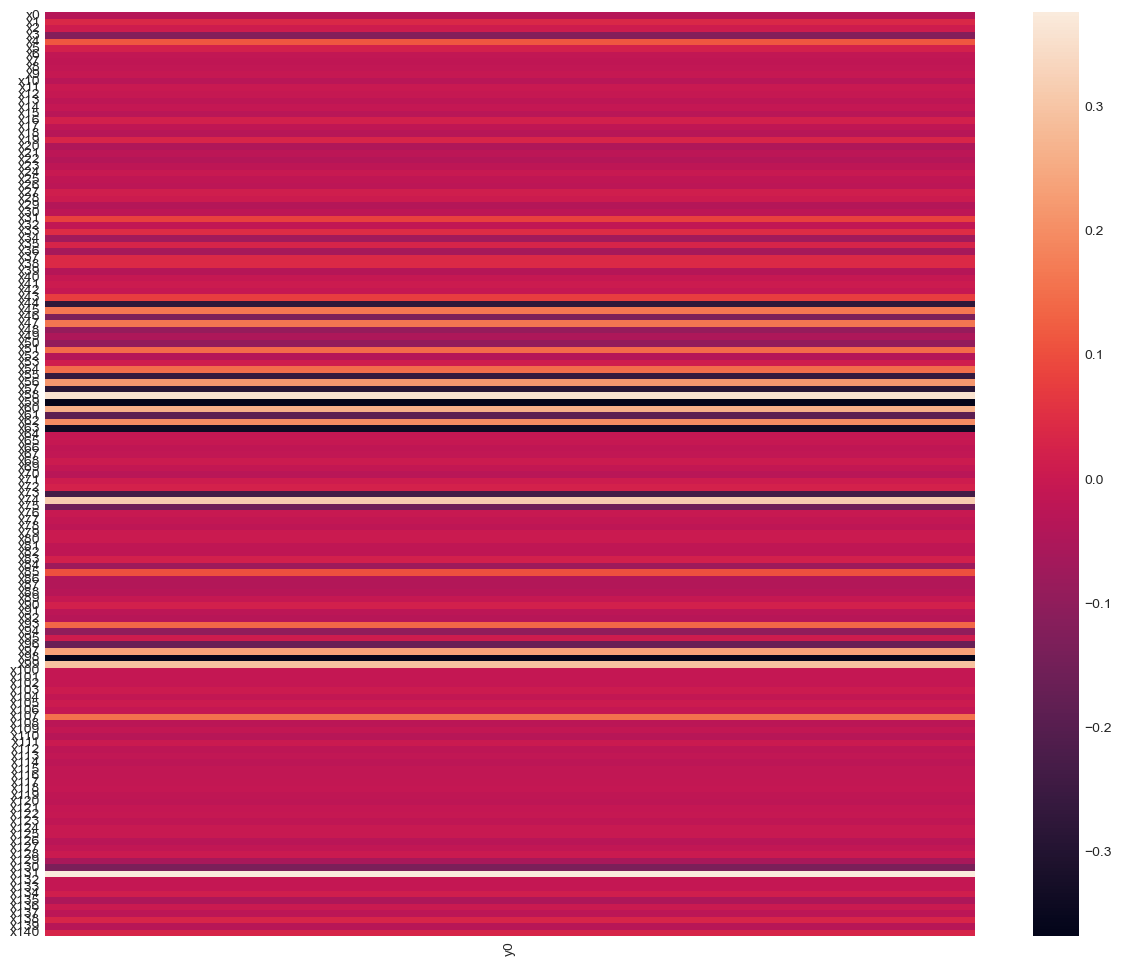

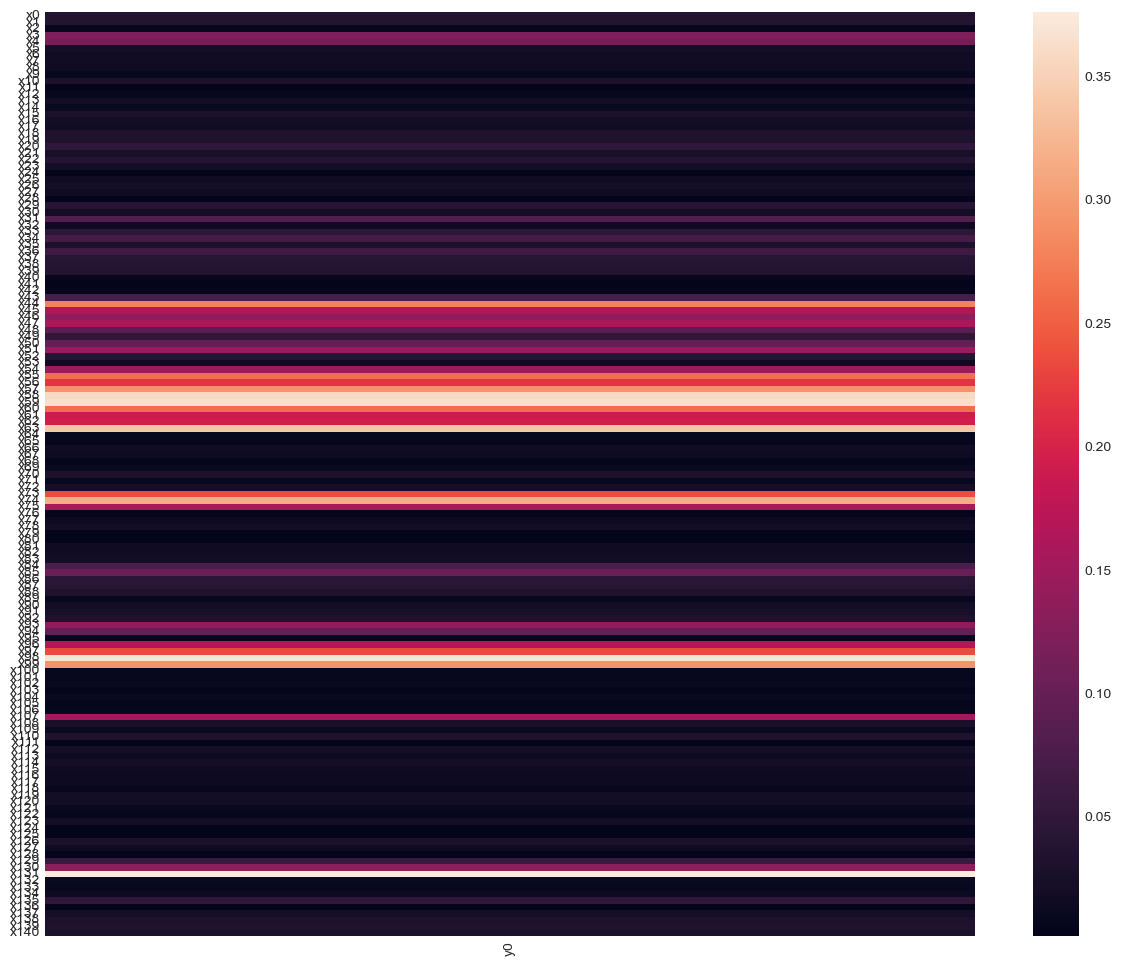

In [165]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = G_inv_sqrt @ U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)    
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

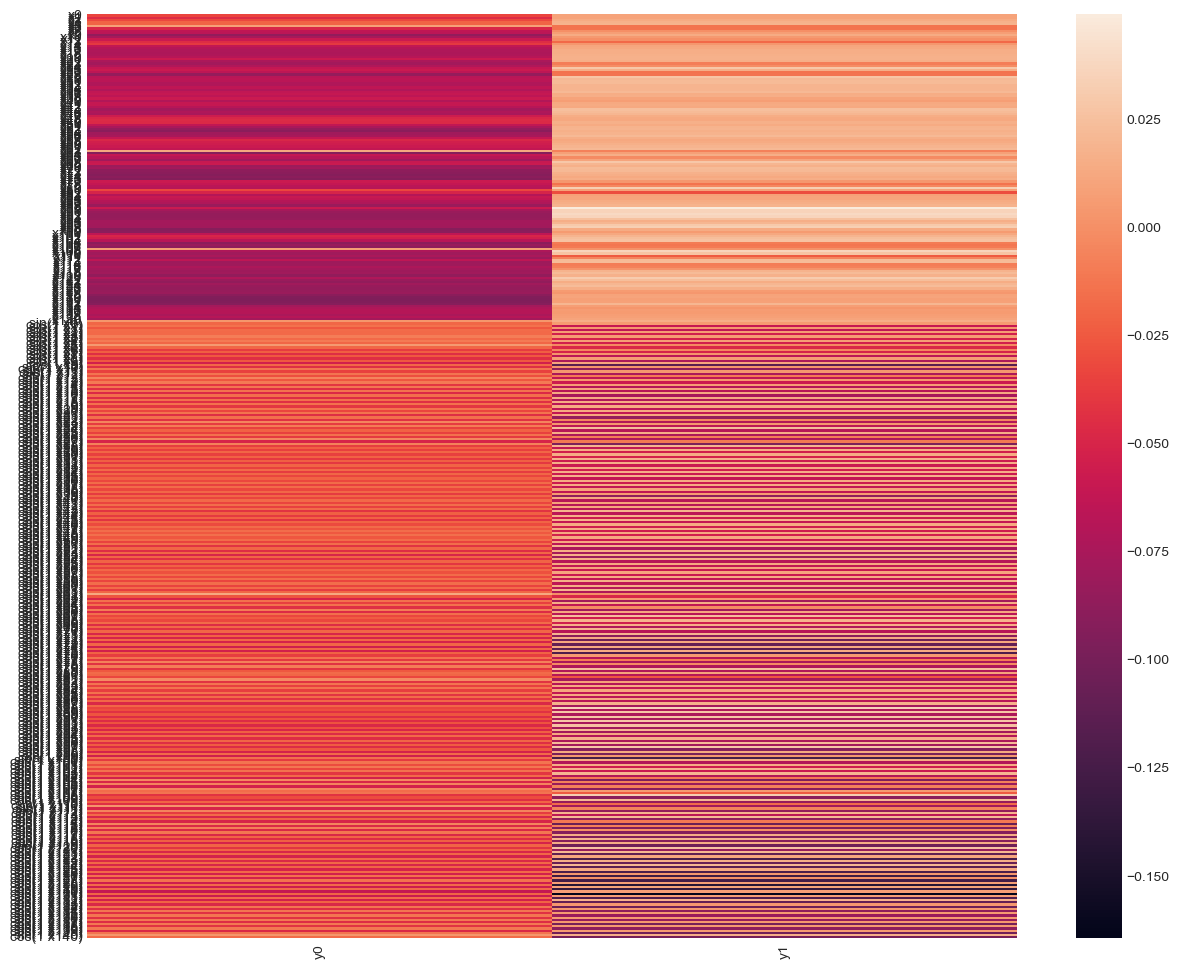

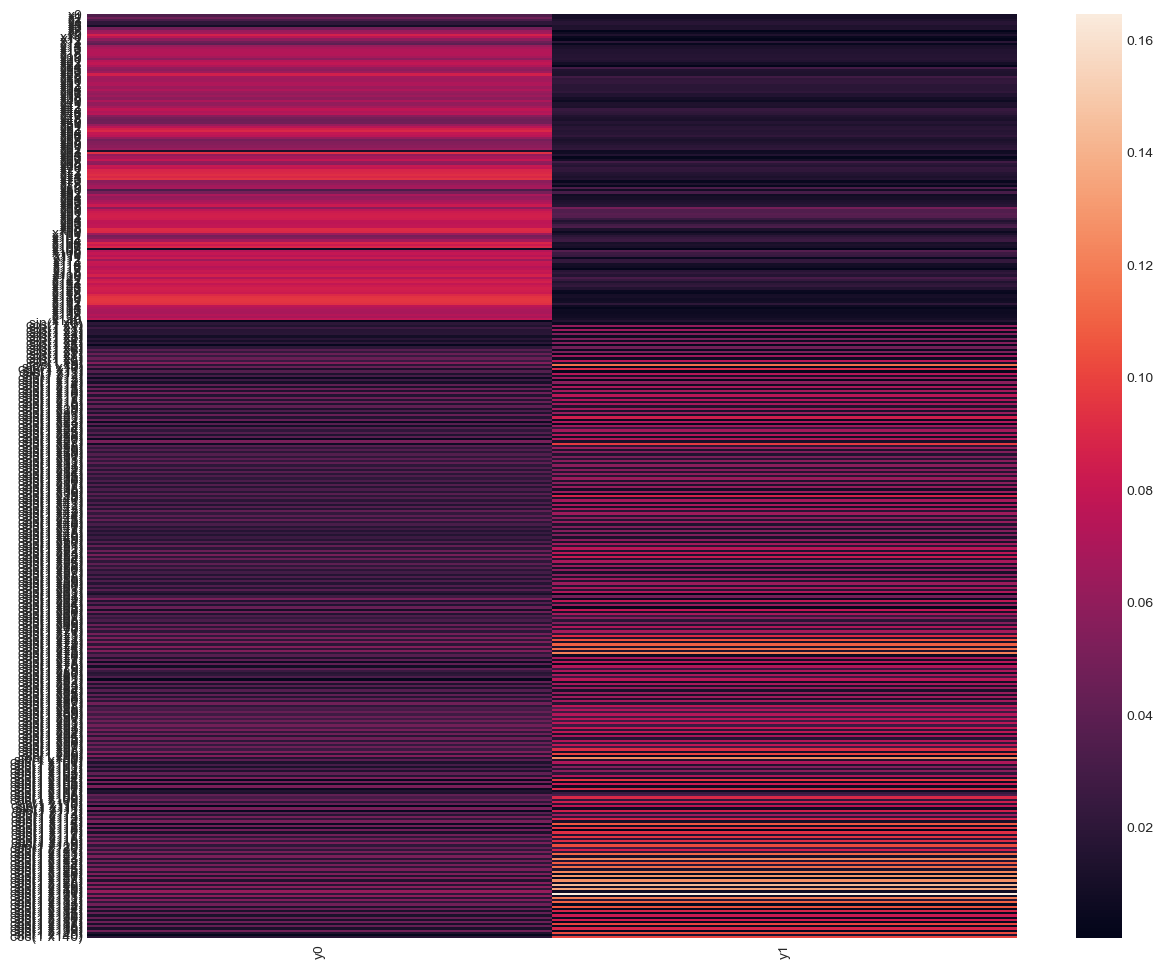

In [147]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)    
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [166]:
# coarse_grain_coff = U[:, :rank]
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.0359 * x0 + 0.0366 * x1 + 0.0068 * x2 - 0.1200 * x3 + 0.1128 * x4 + 0.0192 * x5 - 0.0151 * x6 - 0.0179 * x7 - 0.0149 * x8 - 0.0074 * x9 - 0.0296 * x10 - 0.0015 * x11 - 0.0073 * x12 - 0.0203 * x13 - 0.0104 * x14 - 0.0291 * x15 + 0.0200 * x16 - 0.0183 * x17 - 0.0331 * x18 + 0.0308 * x19 - 0.0475 * x20 - 0.0255 * x21 - 0.0393 * x22 - 0.0204 * x23 - 0.0027 * x24 - 0.0187 * x25 - 0.0226 * x26 + 0.0148 * x27 + 0.0038 * x28 - 0.0390 * x29 - 0.0202 * x30 + 0.0816 * x31 - 0.0146 * x32 + 0.0465 * x33 - 0.0698 * x34 + 0.0281 * x35 - 0.0630 * x36 + 0.0405 * x37 + 0.0389 * x38 - 0.0356 * x39 - 0.0072 * x40 + 0.0043 * x41 - 0.0071 * x42 + 0.0740 * x43 - 0.2782 * x44 + 0.1624 * x45 - 0.1354 * x46 + 0.1612 * x47 - 0.0903 * x48 - 0.0502 * x49 - 0.0965 * x50 + 0.1447 * x51 - 0.0394 * x52 + 0.0150 * x53 + 0.1472 * x54 - 0.2627 * x55 + 0.2168 * x56 - 0.2923 * x57 + 0.3573 * x58 - 0.3650 * x59 + 0.2608 * x60 - 0.1891 * x61 + 0.1957 * x62 - 0.3386 * x63 - 0.0088 * x64 - 0.0069 * x65 - 0.0187 * x66 -

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/1827495546.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


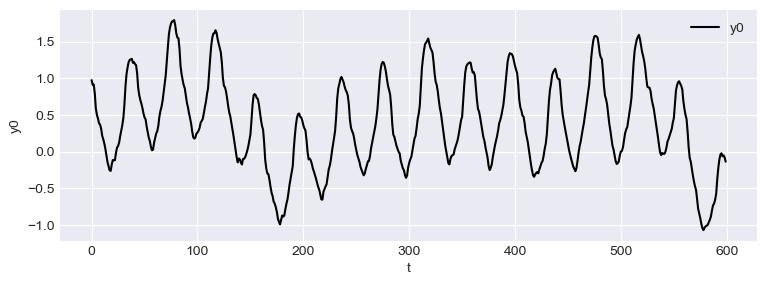

In [167]:
macro_data = x_data_lift[0] @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, int(3*macro_dim)))
if macro_dim > 1:
    for i in range(macro_dim):
        axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
        axs[i].legend()
        axs[i].set(xlabel="t", ylabel=f"y{i}")
else:
    for i in range(macro_dim):
        axs.plot(macro_data[:, i], "k", label=f"y{i}")
        axs.legend()
        axs.set(xlabel="t", ylabel=f"y{i}")
fig.show()

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/3986269945.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


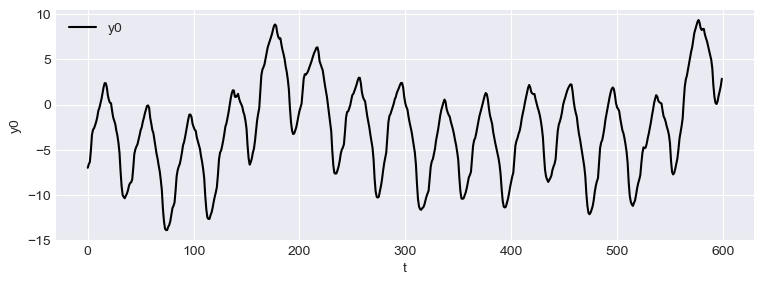

In [126]:
macro_data = x_data_lift[0] @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, int(3*macro_dim)))
for i in range(macro_dim):
    axs.plot(macro_data[:, i], "k", label=f"y{i}")
    axs.legend()
    axs.set(xlabel="t", ylabel=f"y{i}")
fig.show()

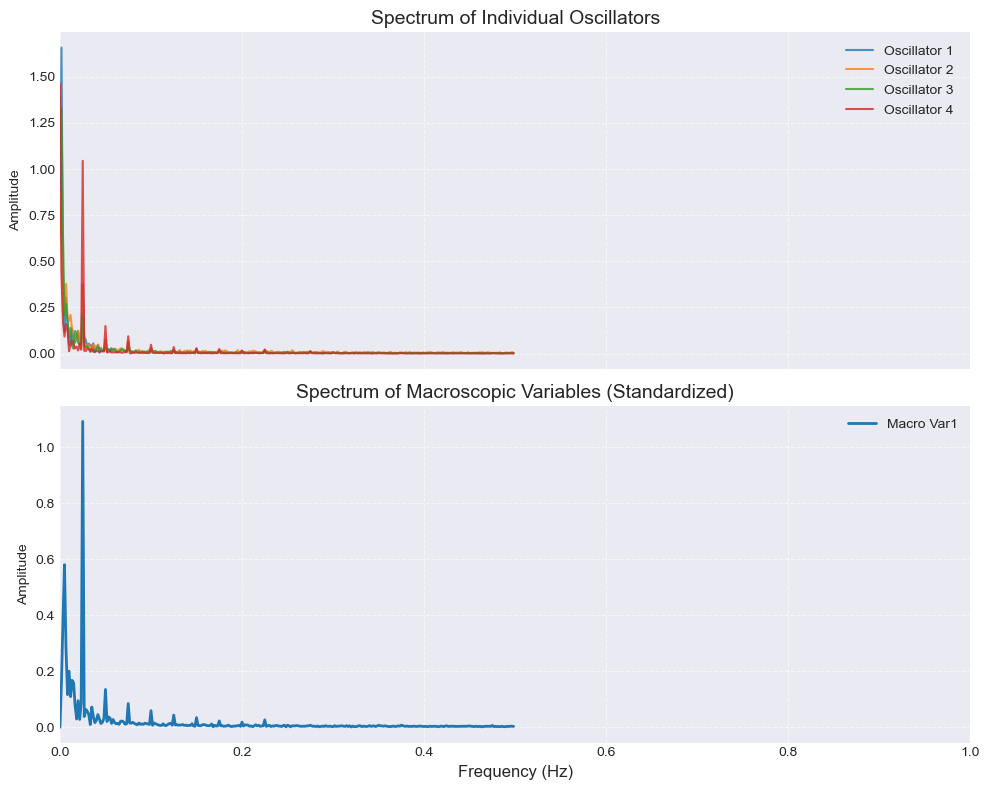

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

N=len(macro_data[:,0])
xf = np.fft.fftfreq(N, dt) 
x_data_seq = x_data[0]
micro_signals = [x_data_seq[:, 0], x_data_seq[:, 5], x_data_seq[:, 1], x_data_seq[:, 6]]
micro_labels = [
    'Oscillator 1 ', 
    'Oscillator 2 ', 
    'Oscillator 3 ', 
    'Oscillator 4 '
]

# 扩充 Colors：使用不同颜色区分不同指标，或同色系区分不同集群
# 这里补充了绿色和红色，分别对应蓝、橙、绿、红
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 

macro_signals = []
for i in range(macro_dim):
    sig = macro_data[:,i]
    standardized_sig = (sig - np.mean(sig) ) / np.std(sig)
    macro_signals.append(standardized_sig)
macro_labels = ['Macro Var1', 'Macro Var2', 'Macro Var3']

def compute_fft(signal, xf, N):
    yf = fft(signal)
    half_n = N // 2
    return xf[:half_n], np.abs(yf[:half_n]) / N * 2  # 归一化幅值


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- 第一幅图：原振子数据的频谱 ---
for i, sig in enumerate(micro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax1.plot(freqs, amps, label=micro_labels[i], color=colors[i], alpha=0.8)

ax1.set_title("Spectrum of Individual Oscillators", fontsize=14)
ax1.set_ylabel("Amplitude")
ax1.legend(loc="upper right")
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 第二幅图：宏观变量的频谱 (已标准化) ---
for i, sig in enumerate(macro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax2.plot(freqs, amps, label=macro_labels[i], color=colors[i], linewidth=2)

ax2.set_title("Spectrum of Macroscopic Variables (Standardized)", fontsize=14)
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("Amplitude")
ax2.legend(loc="upper right")
ax2.grid(True, linestyle='--', alpha=0.6)

# 设置显示范围 (为了看清主峰，限制x轴范围)
ax2.set_xlim(0, 1) 

plt.tight_layout()
plt.show()
